In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
import subprocess as sp
from scipy.stats.mstats import zscore

from scipy.stats import pearsonr, spearmanr

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
def hyper_test(M, n, N, k):
    '''
    Calculates the hypergeometric test.
    
    Input:
      M: Population size (total exons tested)
      n: Successess in population (exons with p-value <= x)
      N: Sample size (exons selected)
      k: Successes in sample (selected exons with p-value <= x)
    Output:
      p_depleted: p-value of depletion from the hypergeometric test
      p_enriched: p-value of enrichment from the hypergeometric test
    '''
    hpd = hypergeom(M, n, N) # Hypergeometric distribution
    p_depleted = hpd.cdf(k)  # Get cummulative distribution up to k
    p_enriched = hpd.sf(k-1) # Survival function up to k-1 (1 - cdf(k-1))
    return p_depleted, p_enriched


def test_enrichment(binding, exon_cluster):
    M = len(binding)
    n = binding.sum()
    N = len(exon_cluster)
    k = binding.loc[exon_cluster].sum()
    p_depleted, p_enriched = hyper_test(M, n, N, k)
    
    enrichment = (k/N)/(n/M)
    
    if enrichment == 0:
        log_enrich = -3
    else:
        log_enrich = np.log2(enrichment)
        
    
    return p_enriched, p_depleted, log_enrich

from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm


In [3]:
psix_results = pd.read_csv('psix_3D/psix_results.tab.gz', sep='\t', index_col=0)
modules = pd.read_csv('psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module
psi =  pd.read_csv('data/preprocess/tables/psi_3D.tab.gz', sep='\t', index_col=0)
mrna_per_event =  pd.read_csv('data/preprocess/tables/mrna_per_event_3D.tab.gz', sep='\t', index_col=0)
neighbors_psi = pd.read_csv('data/preprocess/tables/neighbors_psi_3D.tab.gz', sep='\t', index_col=0)
latent = pd.read_csv('data/preprocess/tables/pc3_rd.tab.gz', sep='\t', index_col=0)
norm_expression = pd.read_csv('data/preprocess/tables/scone_norm_tpm_extended.tab.gz', sep='\t', index_col=0)[latent.index]

from sklearn.preprocessing import StandardScaler
# scaled_counts = pd.DataFrame(StandardScaler().fit_transform(norm_expression.T).T)
# scaled_counts.index = norm_expression.index
# scaled_counts.columns = norm_expression.columns

meta = pd.read_csv('data/SraRunTable.txt.gz', index_col=0).loc[latent.index]

p90_cells = meta.loc[meta.Age == 'postnatal day 90'].index 
p1_cells = meta.loc[meta.Age == 'postnatal day 1'].index 
e18_cells = meta.loc[meta.Age == 'embryonic day 18.5'].index 
e15_cells = meta.loc[meta.Age == 'embryonic day 15.5'].index 
e13_cells = meta.loc[meta.Age == 'embryonic day 13.5'].index 

In [4]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
mouse_clip_peaks = mouse_clip_peaks[[x for x in mouse_clip_peaks.columns if x != 'AGO2']]
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']

In [5]:
sig_exons = psix_results.loc[(psix_results.qvals <= 0.05) & (psix_results.psix_score > 0)].index

pval_hyper = pd.DataFrame(np.zeros((4, 31)), columns = mouse_clip_peaks.columns, index = ['e1', 's1', 's2', 'e2'])
enrichment_hyper = pd.DataFrame(np.zeros((4, 31)), columns = mouse_clip_peaks.columns, index = ['e1', 's1', 's2', 'e2'])

for RBP in mouse_clip_peaks.columns:
    for region in ['e1', 's1', 's2', 'e2']:
        
        region_exons = [x for x in mouse_clip_peaks.index if x[-3:]==('_' + region)]
        
        hyper = test_enrichment(mouse_clip_peaks.loc[region_exons, RBP], [x + '_' + region for x in sig_exons])
        pval_hyper.loc[region, RBP] = hyper[0]
        enrichment_hyper.loc[region, RBP] = hyper[2]

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


In [30]:
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(pval_hyper).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(4,-32),#<=0.1,
                                        columns = mouse_clip_peaks.columns, index = ['e1', 's1', 's2', 'e2'])

In [51]:
pval_hyper.columns[(multipletests(np.array(pval_hyper).reshape(1,-1)[0],  method='fdr_bh')[1].reshape(4,-32) <= 0.05).sum(axis=0) > 0]

Index(['SRSF1', 'LIN28A', 'RBM3', 'RBFOX3', 'MBNL1', 'SRSF6', 'NOVA2', 'SRSF2',
       'MBNL2', 'CELF4', 'SRSF5', 'NOVA1', 'TARDBP', 'SRSF7', 'U2AF2', 'FUS',
       'RBFOX2', 'SRSF4', 'RBFOX1', 'CIRBP', 'SRSF3'],
      dtype='object')

In [58]:
from scipy.stats import pearsonr, spearmanr
def nan_pearsonr(x, y):
    non_nan = y.dropna().index
    if len(non_nan) < 15:
        return (np.nan, 1)
    return pearsonr(x.loc[non_nan], y.loc[non_nan])

In [62]:
sf_list = ['Celf4', 'Cirbp', 'Fus', 'Lin28a', 'Mbnl1', 'Mbnl2', 'Nova1', 'Nova2', 'Ptbp1', 'Ptbp2',
           'Rbfox1', 'Rbfox2', 'Rbfox3', 'Srsf1', 'Srsf2', 'Srsf3', 'Srsf4', 'Srsf6', 'Srsf7', 'Tardbp', 'U2af2']
sf_list = [x for x in sf_list if x in norm_expression.index]

sf_list2 = ['Celf1', 'Elavl1', 'Ezh2', 'Fmr1', 'Pabpc1', 'Srrm4', 'Taf15', 'Upf1']
sf_list2 = [x for x in sf_list2 if x in norm_expression.index]



pearsonr_pos_list = []
pearsonr_neg_list = []
for exon in tqdm(sig_exons, position= 0, leave=True):
    for sf in sf_list:
        pearsonr_pos_list.append(
            nan_pearsonr(
                norm_expression.loc[sf], psi.loc[exon]
            )
        )
        
    for sf in sf_list2:
        pearsonr_neg_list.append(
            nan_pearsonr(
                norm_expression.loc[sf], psi.loc[exon]
            )
        )
        

100%|██████████| 798/798 [00:46<00:00, 17.17it/s]


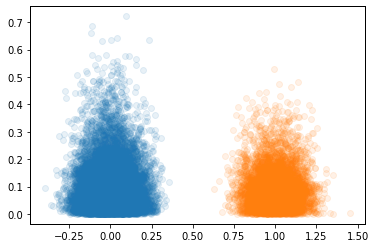

In [74]:
plt.scatter(np.random.normal(0, 0.1, 15960), [np.abs(x[0]) for x in pearsonr_pos_list], alpha=0.1)
plt.scatter(np.random.normal(1, 0.1, 6384), [np.abs(x[0]) for x in pearsonr_neg_list], alpha=0.1)

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0a513f1c50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0a513f1a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0a51207110>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0a4eb73110>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0a5106b650>,
 'means': []}

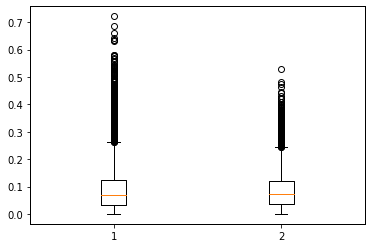

In [80]:
plt.boxplot([[np.abs(x[0]) for x in pearsonr_pos_list], [np.abs(x[0]) for x in pearsonr_neg_list]])



In [67]:
len([np.abs(x[0]) for x in pearsonr_pos_list])

15960

100%|██████████| 20/20 [00:00<00:00, 56.87it/s]


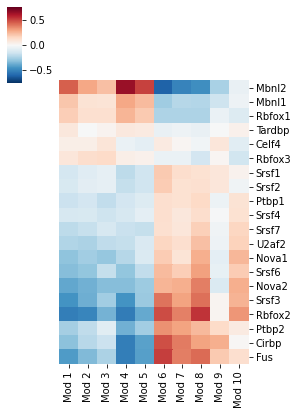

In [75]:
module_avg = pd.DataFrame()


sf_list = ['Celf4', 'Cirbp', 'Fus', 'Lin28a', 'Mbnl1', 'Mbnl2', 'Nova1', 'Nova2', 'Ptbp1', 'Ptbp2',
           'Rbfox1', 'Rbfox2', 'Rbfox3', 'Srsf1', 'Srsf2', 'Srsf3', 'Srsf4', 'Srsf6', 'Srsf7', 'Tardbp', 'U2af2']

sf_list = [x for x in sf_list if x in norm_expression.index]

for mod in range(1, 11):
    module_avg['module_' + str(mod)] = np.nanmean(zscore(psi.loc[modules.index[modules == mod]], axis=1, 
                                             nan_policy='omit'), axis=0)
    
module_avg.index = psi.columns
module_avg = module_avg.T


module_avg_corr = pd.DataFrame(np.zeros((len(sf_list), len(module_avg.index))), 
                               index = sf_list, columns = module_avg.index)
for sf in tqdm(sf_list):
    for mod in module_avg.index:
        module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
                                                norm_expression.loc[sf, module_avg.columns]
        )[0]
        
# module_avg_corr = pd.DataFrame(np.zeros((len(sf_neighbors.index), len(module_avg.index))), 
#                                index = sf_neighbors.index, columns = module_avg.index)
# for sf in tqdm(sf_neighbors.index):
#     for mod in module_avg.index:
#         module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
#                                                 norm_expression.loc[sf, module_avg.columns]
#         )[0]

mod_order = ['module_1', 'module_2', 'module_3', 'module_4', 'module_5',
             'module_6', 'module_7', 'module_8', 'module_9', 'module_10']

mod_cor = module_avg_corr.loc[sf_list, mod_order]
mod_cor.columns = ['Mod 1', 'Mod 2', 'Mod 3', 'Mod 4', 'Mod 5',
             'Mod 6', 'Mod 7', 'Mod 8', 'Mod 9', 'Mod 10']

cg = sns.clustermap(mod_cor, 
               col_cluster=False,
#               row_colors = gene_mod_colors, 
               row_cluster=True, vmin=-0.75, vmax=0.75, cmap='RdBu_r', figsize=(10/2.4, 14/2.4))

cg.ax_row_dendrogram.set_visible(False)

# plt.show()
plt.savefig('plots/module_correlations.png', bbox_inches='tight', res=20000, dpi =2000)

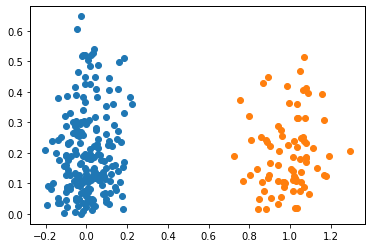

In [77]:
plt.scatter(np.random.normal(0, 0.1, 200), mod_cor.abs())
plt.scatter(np.random.normal(1, 0.1, 80), module_avg_corr.abs())
plt.show()

In [96]:
mod_cor.abs().max(axis=1)

Celf4     0.094127
Cirbp     0.520419
Fus       0.520196
Mbnl1     0.289156
Mbnl2     0.647359
Nova1     0.302626
Nova2     0.390111
Ptbp1     0.182594
Ptbp2     0.359252
Rbfox1    0.253145
Rbfox2    0.539525
Rbfox3    0.145656
Srsf1     0.197968
Srsf2     0.188512
Srsf3     0.448047
Srsf4     0.152667
Srsf6     0.317865
Srsf7     0.197822
Tardbp    0.084866
U2af2     0.234703
dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0a4caf5050>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0a4ca66a50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0a4cafe310>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0a4cb5ad50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0a4cb5ae10>,
 'means': []}

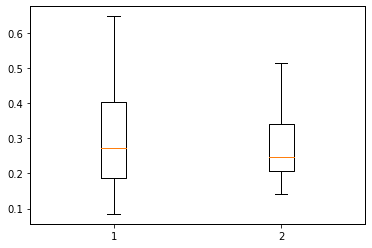

In [97]:
plt.boxplot([mod_cor.abs().max(axis=1), module_avg_corr.abs().max(axis=1)])


100%|██████████| 8/8 [00:00<00:00, 52.62it/s]


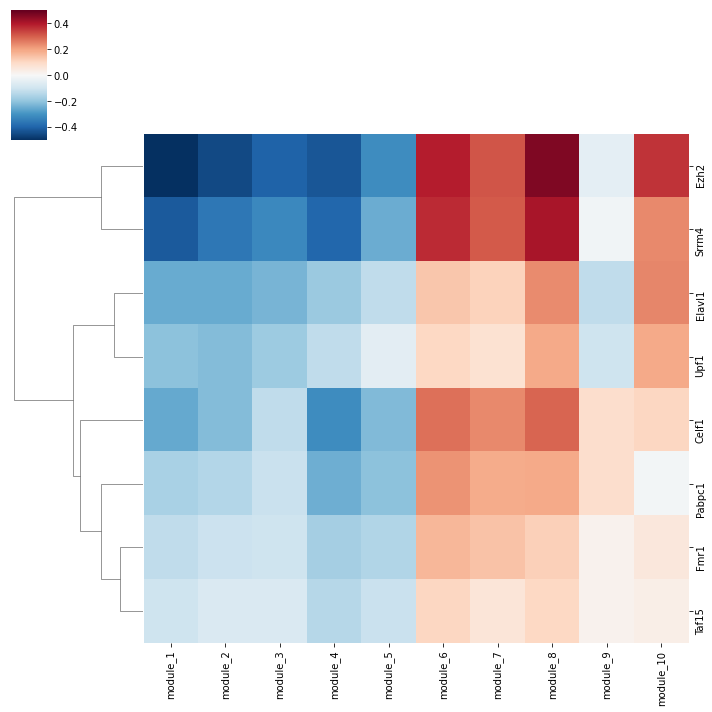

In [76]:
module_avg = pd.DataFrame()

sf_list2 = ['Celf1', 'Elavl1', 'Ezh2', 'Fmr1', 'Pabpc1', 'Srrm4', 'Taf15', 'Upf1']

sf_list2 = [x for x in sf_list2 if x in norm_expression.index]

for mod in range(1, 11):
    module_avg['module_' + str(mod)] = np.nanmean(zscore(psi.loc[modules.index[modules == mod]], axis=1, 
                                             nan_policy='omit'), axis=0)
    
module_avg.index = psi.columns
module_avg = module_avg.T


module_avg_corr = pd.DataFrame(np.zeros((len(sf_list2), len(module_avg.index))), 
                               index = sf_list2, columns = module_avg.index)
for sf in tqdm(sf_list2):
    for mod in module_avg.index:
        module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
                                                norm_expression.loc[sf, module_avg.columns]
        )[0]
        
# module_avg_corr = pd.DataFrame(np.zeros((len(sf_neighbors.index), len(module_avg.index))), 
#                                index = sf_neighbors.index, columns = module_avg.index)
# for sf in tqdm(sf_neighbors.index):
#     for mod in module_avg.index:
#         module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
#                                                 norm_expression.loc[sf, module_avg.columns]
#         )[0]

mod_order = ['module_1', 'module_2', 'module_3', 'module_4', 'module_5',
             'module_6', 'module_7', 'module_8', 'module_9', 'module_10']
sns.clustermap(module_avg_corr.loc[sf_list2, mod_order], 
               col_cluster=False,
#               row_colors = gene_mod_colors, 
               row_cluster=True, vmin=-0.5, vmax=0.5, cmap='RdBu_r')

plt.show()
# plt.savefig('plots/exon_modules.png', bbox_inches='tight', res=20000, dpi =2000)

In [12]:
module_avg_corr

,module_1,module_2,module_3,module_4,module_5,module_6,module_7,module_8,module_9,module_10
Celf1,-0.253977,-0.218003,-0.125171,-0.313144,-0.221217,0.275176,0.238707,0.289125,0.089795,0.108463
Elavl1,-0.252284,-0.252432,-0.232109,-0.185705,-0.125421,0.138885,0.117085,0.236972,-0.128733,0.243886
Ezh2,-0.513476,-0.449351,-0.406012,-0.429527,-0.315481,0.392650,0.314352,0.467033,-0.049200,0.362638
Fmr1,-0.126054,-0.106973,-0.103624,-0.170365,-0.152092,0.167866,0.147061,0.117487,0.020513,0.055806
Pabpc1,-0.160668,-0.145938,-0.110685,-0.242836,-0.205998,0.224310,0.184154,0.191228,0.089299,-0.015097
Srrm4,-0.419191,-0.360222,-0.321334,-0.397419,-0.248416,0.371574,0.306368,0.413031,-0.017459,0.240485
Taf15,-0.102650,-0.074375,-0.076435,-0.140628,-0.111445,0.109178,0.065501,0.103203,0.021170,0.033203
Upf1,-0.206149,-0.217404,-0.180116,-0.127910,-0.053211,0.103257,0.076796,0.190669,-0.104431,0.188140


In [11]:
sig_exons = psix_results.loc[(psix_results.qvals <= 0.05) & (psix_results.psix_score > 0)].index

mod_list = []
for i in range(1, 11):
    for j in ['e1', 's1', 's2', 'e2']:
        mod_list.append('module_' + str(i) + '_' + j)

pval_hyper = pd.DataFrame(np.zeros((40, 31)), columns = mouse_clip_peaks.columns, index = mod_list)
enrichment_hyper = pd.DataFrame(np.zeros((40, 31)), columns = mouse_clip_peaks.columns, index = mod_list)

for RBP in tqdm(mouse_clip_peaks.columns, position=0, leave=True):
    
    for i in range(1, 11):
    
        for region in ['e1', 's1', 's2', 'e2']:
            
            mod_exons = modules.index[modules == i]
        
            region_exons = [x for x in mouse_clip_peaks.index if x[-3:]==('_' + region)]

            hyper = test_enrichment(mouse_clip_peaks.loc[region_exons, RBP], [x + '_' + region for x in mod_exons])
            
            mod_name = 'module_' + str(i) + '_' + region
            
            pval_hyper.loc[mod_name, RBP] = hyper[0]
            enrichment_hyper.loc[mod_name, RBP] = hyper[2]

100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


In [12]:
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(pval_hyper).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(40,-31),#<=0.1,
                                        columns = mouse_clip_peaks.columns, index = mod_list)

In [13]:
bound_rbps = sorted(hyper_enrich_significance.columns[(hyper_enrich_significance <= 0.05).sum() >= 1])

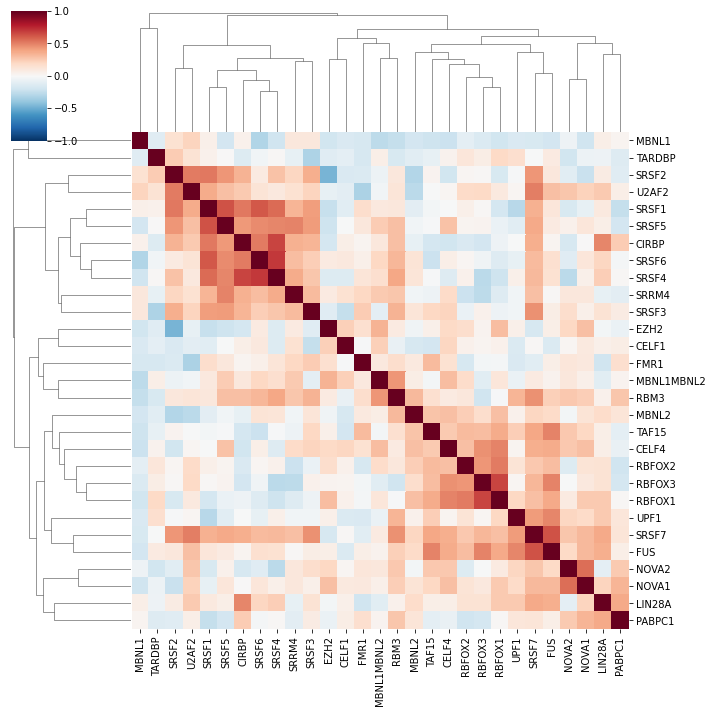

In [14]:
sns.clustermap(enrichment_hyper.T.dropna().T.corr(), cmap='RdBu_r', vmin=-1)

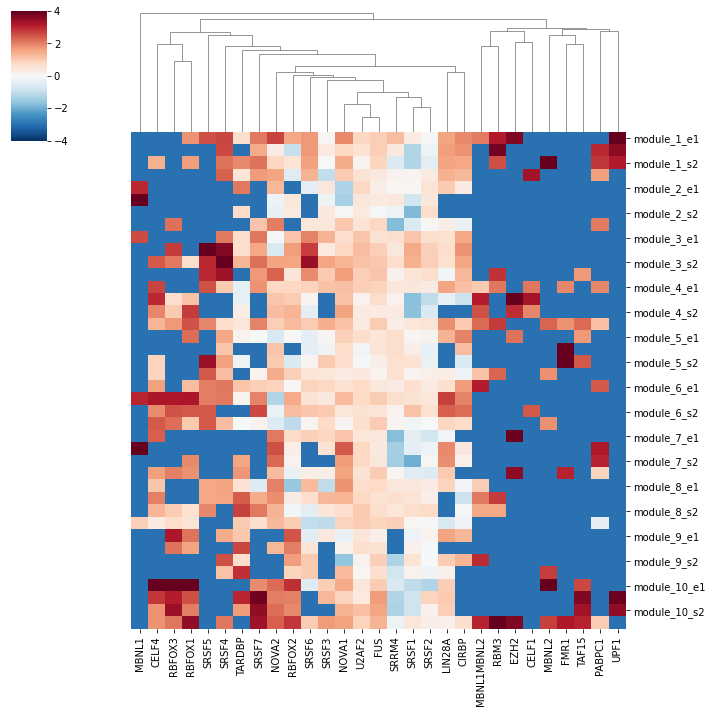

In [15]:
sns.clustermap(enrichment_hyper.T.dropna().T, cmap='RdBu_r', vmax=4, vmin=-4, row_cluster=False)

In [16]:
sf_list = ['Celf4', 'Cirbp', 'Fus', 'Lin28a', 'Mbnl1', 'Mbnl2', 'Nova1', 'Nova2', 'Ptbp1', 'Ptbp2',
           'Rbfox1', 'Rbfox2', 'Rbfox3', 'Srsf1', 'Srsf2', 'Srsf3', 'Srsf4', 'Srsf6', 'Srsf7', 'Tardbp', 'U2af2',
          
          'Celf1', 'Elavl1', 'Ezh2', 'Fmr1', 'Pabpc1', 'Srrm4', 'Taf15', 'Upf1']

sf_list = [x for x in sf_list if x in norm_expression.index]

In [17]:
expressed = norm_expression.loc[norm_expression.mean(axis=1) >= norm_expression.mean(axis=1).quantile(0.1)].index

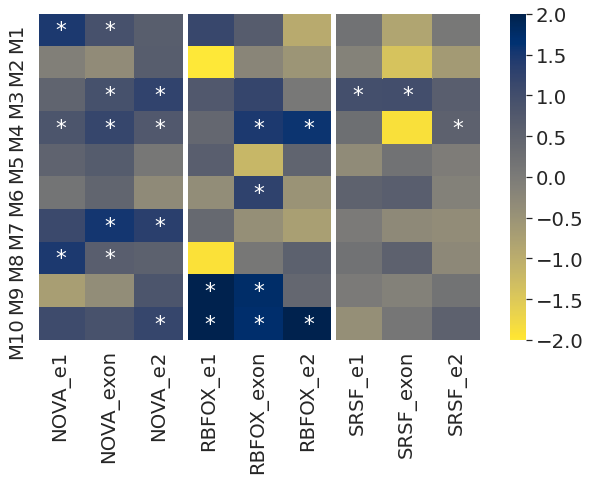

In [20]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_exon'] = ((s1+s2) > 0).astype(int)
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_exon'] = ((s1+s2) > 0).astype(int)
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF1', 'SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['SRSF1', 'SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['SRSF1', 'SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_exon'] = ((s1+s2) > 0).astype(int)

mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF1', 'SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))





# mouse_clip_families['CELF4_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['CELF4']].max(axis=1))
# s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['CELF4']].max(axis=1))
# s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['CELF4']].max(axis=1))
# mouse_clip_families['CELF4_exon'] = ((s1+s2) > 0).astype(int)
# mouse_clip_families['CELF4_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['CELF4']].max(axis=1))



# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]


hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 11):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 11)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(10,-10)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests


sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='cividis_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [186]:
mouse_clip_peaks

,PTBP1,SRSF1,MBNL1MBNL2,LIN28A,FMR1,SRRM4,RBM3,RBFOX3,MBNL1,ELAVL1,...,FUS,EZH2,RBFOX2,CELF1,SRSF4,TAF15,RBFOX1,CIRBP,UPF1,SRSF3
AA467197_1_e1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aacs_2_e1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aaed1_1_e1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aak1_2_e1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Aamdc_10_e1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zswim7_1_e2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zufsp_1_e2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Zyx_1_e2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Zyx_2_e2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


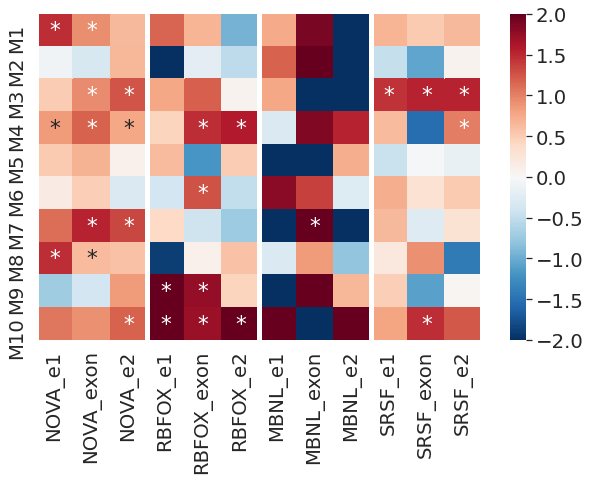

In [19]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_exon'] = ((s1+s2) > 0).astype(int)
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_exon'] = ((s1+s2) > 0).astype(int)
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
mouse_clip_families['MBNL_exon'] = ((s1+s2) > 0).astype(int)
mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_exon'] = ((s1+s2) > 0).astype(int)

mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]


hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 11):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 11)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(10,-10)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests


sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

(2087, 12)


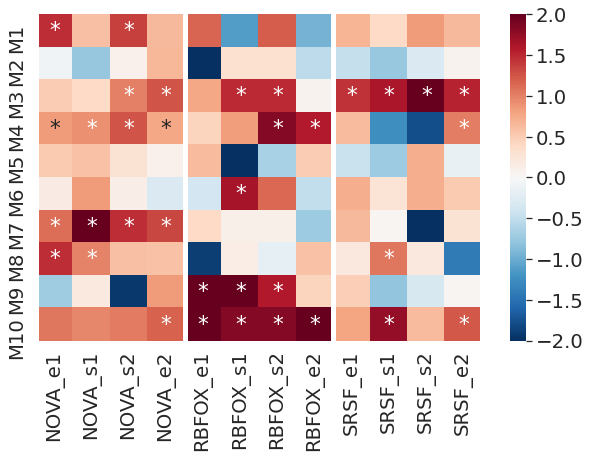

In [14]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]
# mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

print(mouse_clip_families.shape)

# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 11):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 11)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(10,-10)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests


sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

(2087, 12)


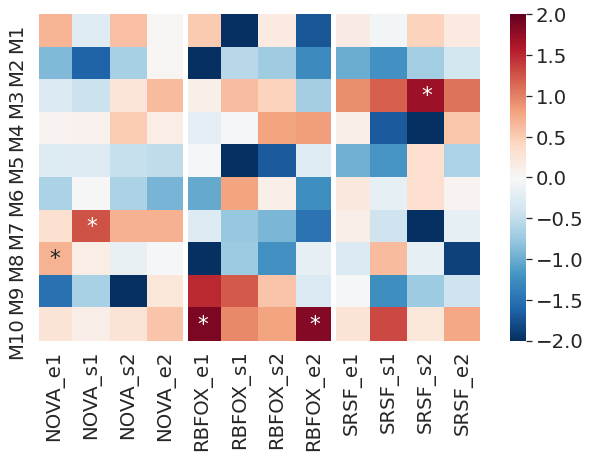

In [16]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']


mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]
# mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

print(mouse_clip_families.shape)

# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 11):
        enrichment = test_enrichment(mouse_clip_families.loc[modules.index, rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 11)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(10,-10)<=0.15)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests


sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()